# Tests de Word2Vec avec des vecteurs [NLPL](http://vectors.nlpl.eu/repository/)

## Français (NLPL/43)
Corpus :
- French CoNLL17 corpus
    - français, minuscules, sans lemmes, sans tags
    - 5494845765 tokens

Créé par Andrey Kutuzov (andreku@ifi.uio.no)

Paramètres :
- skipgram
- 100 dimensions
- fenêtre 10 mots
- taille du vocabulaire : 2567698 mots 

In [25]:
import os,gensim
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

data_path= "/votre/chemin/vers/nlpl/" # commentez les autres chemins
data_path="/Users/gilles/Downloads/NLPL/"

In [26]:
path_to_modelFr = os.path.join(data_path,'43/model.bin')
#Load W2V model. This will take some time.
modelFr = KeyedVectors.load_word2vec_format(path_to_modelFr, binary=True)
print('done loading Word2Vec')

done loading Word2Vec


In [27]:
import re
lettres=re.compile(r"^[^\W\d]+$",re.U)

def most_similar(mot="",positive=[],negative=[],topn=10,model=modelFr):
    result=[]
    if mot!="":
        similaires=model.most_similar(mot,topn=2*topn)
    elif positive:
        similaires=model.most_similar(positive=positive,negative=negative,topn=2*topn)
    else:
        print ("pb de paramêtres")
    for similaire in similaires:
        m=lettres.match(similaire[0])
        if m:
            result.append(similaire)
        if len(result)==topn:
            break
    return result


In [28]:
mots=[]
nonMots=[]
for k in modelFr.index_to_key:
    m=lettres.match(k)
    if m:
        mots.append(k)
    else:
        nonMots.append(k)
len(mots),len(nonMots)

(1523344, 1044354)

In [81]:
most_similar("katrash")

KeyError: "Key 'katrash' not present in vocabulary"

In [71]:
most_similar(positive=["oncles","femmes"],negative=["hommes"],topn=5)

[('tantes', 0.8582472205162048), ('nièces', 0.7953529357910156)]

In [53]:
most_similar(positive=["cyclisme","footballeur"],negative=["cycliste"],topn=5)

[('football', 0.7272107005119324),
 ('ngcongca', 0.6924775242805481),
 ('onyewu', 0.6837940216064453),
 ('gelson', 0.6738867163658142),
 ('entraîneur', 0.6723794937133789)]

# Problématique 
Discuter les rapports possibles entre les vecteurs des positions 

- Nom d'Action => production
- Nom d'Agent => producteur/productrice
- Adjectif relationnel => productif/productive
- autres dérivés (productivité, produit, produire, ...)

Est-ce qu'on peut trouver des généralisations sur les vecteurs différences entre ces positions ?
- un vecteur unique pour passer d'une position à une autre (pour qu'on arrive dans le voisinage de la position recherchée)
- un petit nombre de vecteurs pour passer d'une position à une autre

Si on a un petit nombre de vecteurs pour passer d'une position à une autre, est-ce qu'on peut trouver une généralisation pour prédire quel vecteur va marcher ?

## Faire une liste de paires à étudier
- nom d'action (ment-ion-age)/nom d'agent
    - lavage/laveur (eur-euse)
    - production/producteur (eur-rice)
    - accompagnement/accompagnateur (mélangé)
 
## Dérivations standard
- ment formé sur le thème du présent 6 (sulɛv+mâ)
- age formé sur le thème de l'imparfait (eləv+aZ)
- ion formé sur le thème du passé simple plus un t (programa+t+jô) il y a palatalisation du t [avec deux exceptions : gestion et question]

In [8]:
modelFr.most_similar(positive=["construction","producteur"],negative=["constructeur"],topn=5)

[('réalisation', 0.6321220993995667),
 ('production', 0.6101853847503662),
 ('danger1988', 0.5992996096611023),
 ('darbonne', 0.5985347628593445),
 ('ancienne1993', 0.598311722278595)]

In [9]:
modelFr.most_similar(positive=["animant","destructeur"],negative=["animateur"],topn=5)

[('annihilant', 0.7579349875450134),
 ('répandant', 0.709769606590271),
 ('détruisant', 0.7059866189956665),
 ('libérant', 0.70400071144104),
 ('transformant', 0.6994747519493103)]

## Représentation des voisinages en 2D
TSNE permet une réduction de dimension pour visualiser les voisinages sur une carte

In [10]:
def display_closestwords_tsnescatterplot(model, word, size,topn=10):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.similar_by_word(word,topn=topn)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.figure(figsize=(50,50))
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',fontsize=50)
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

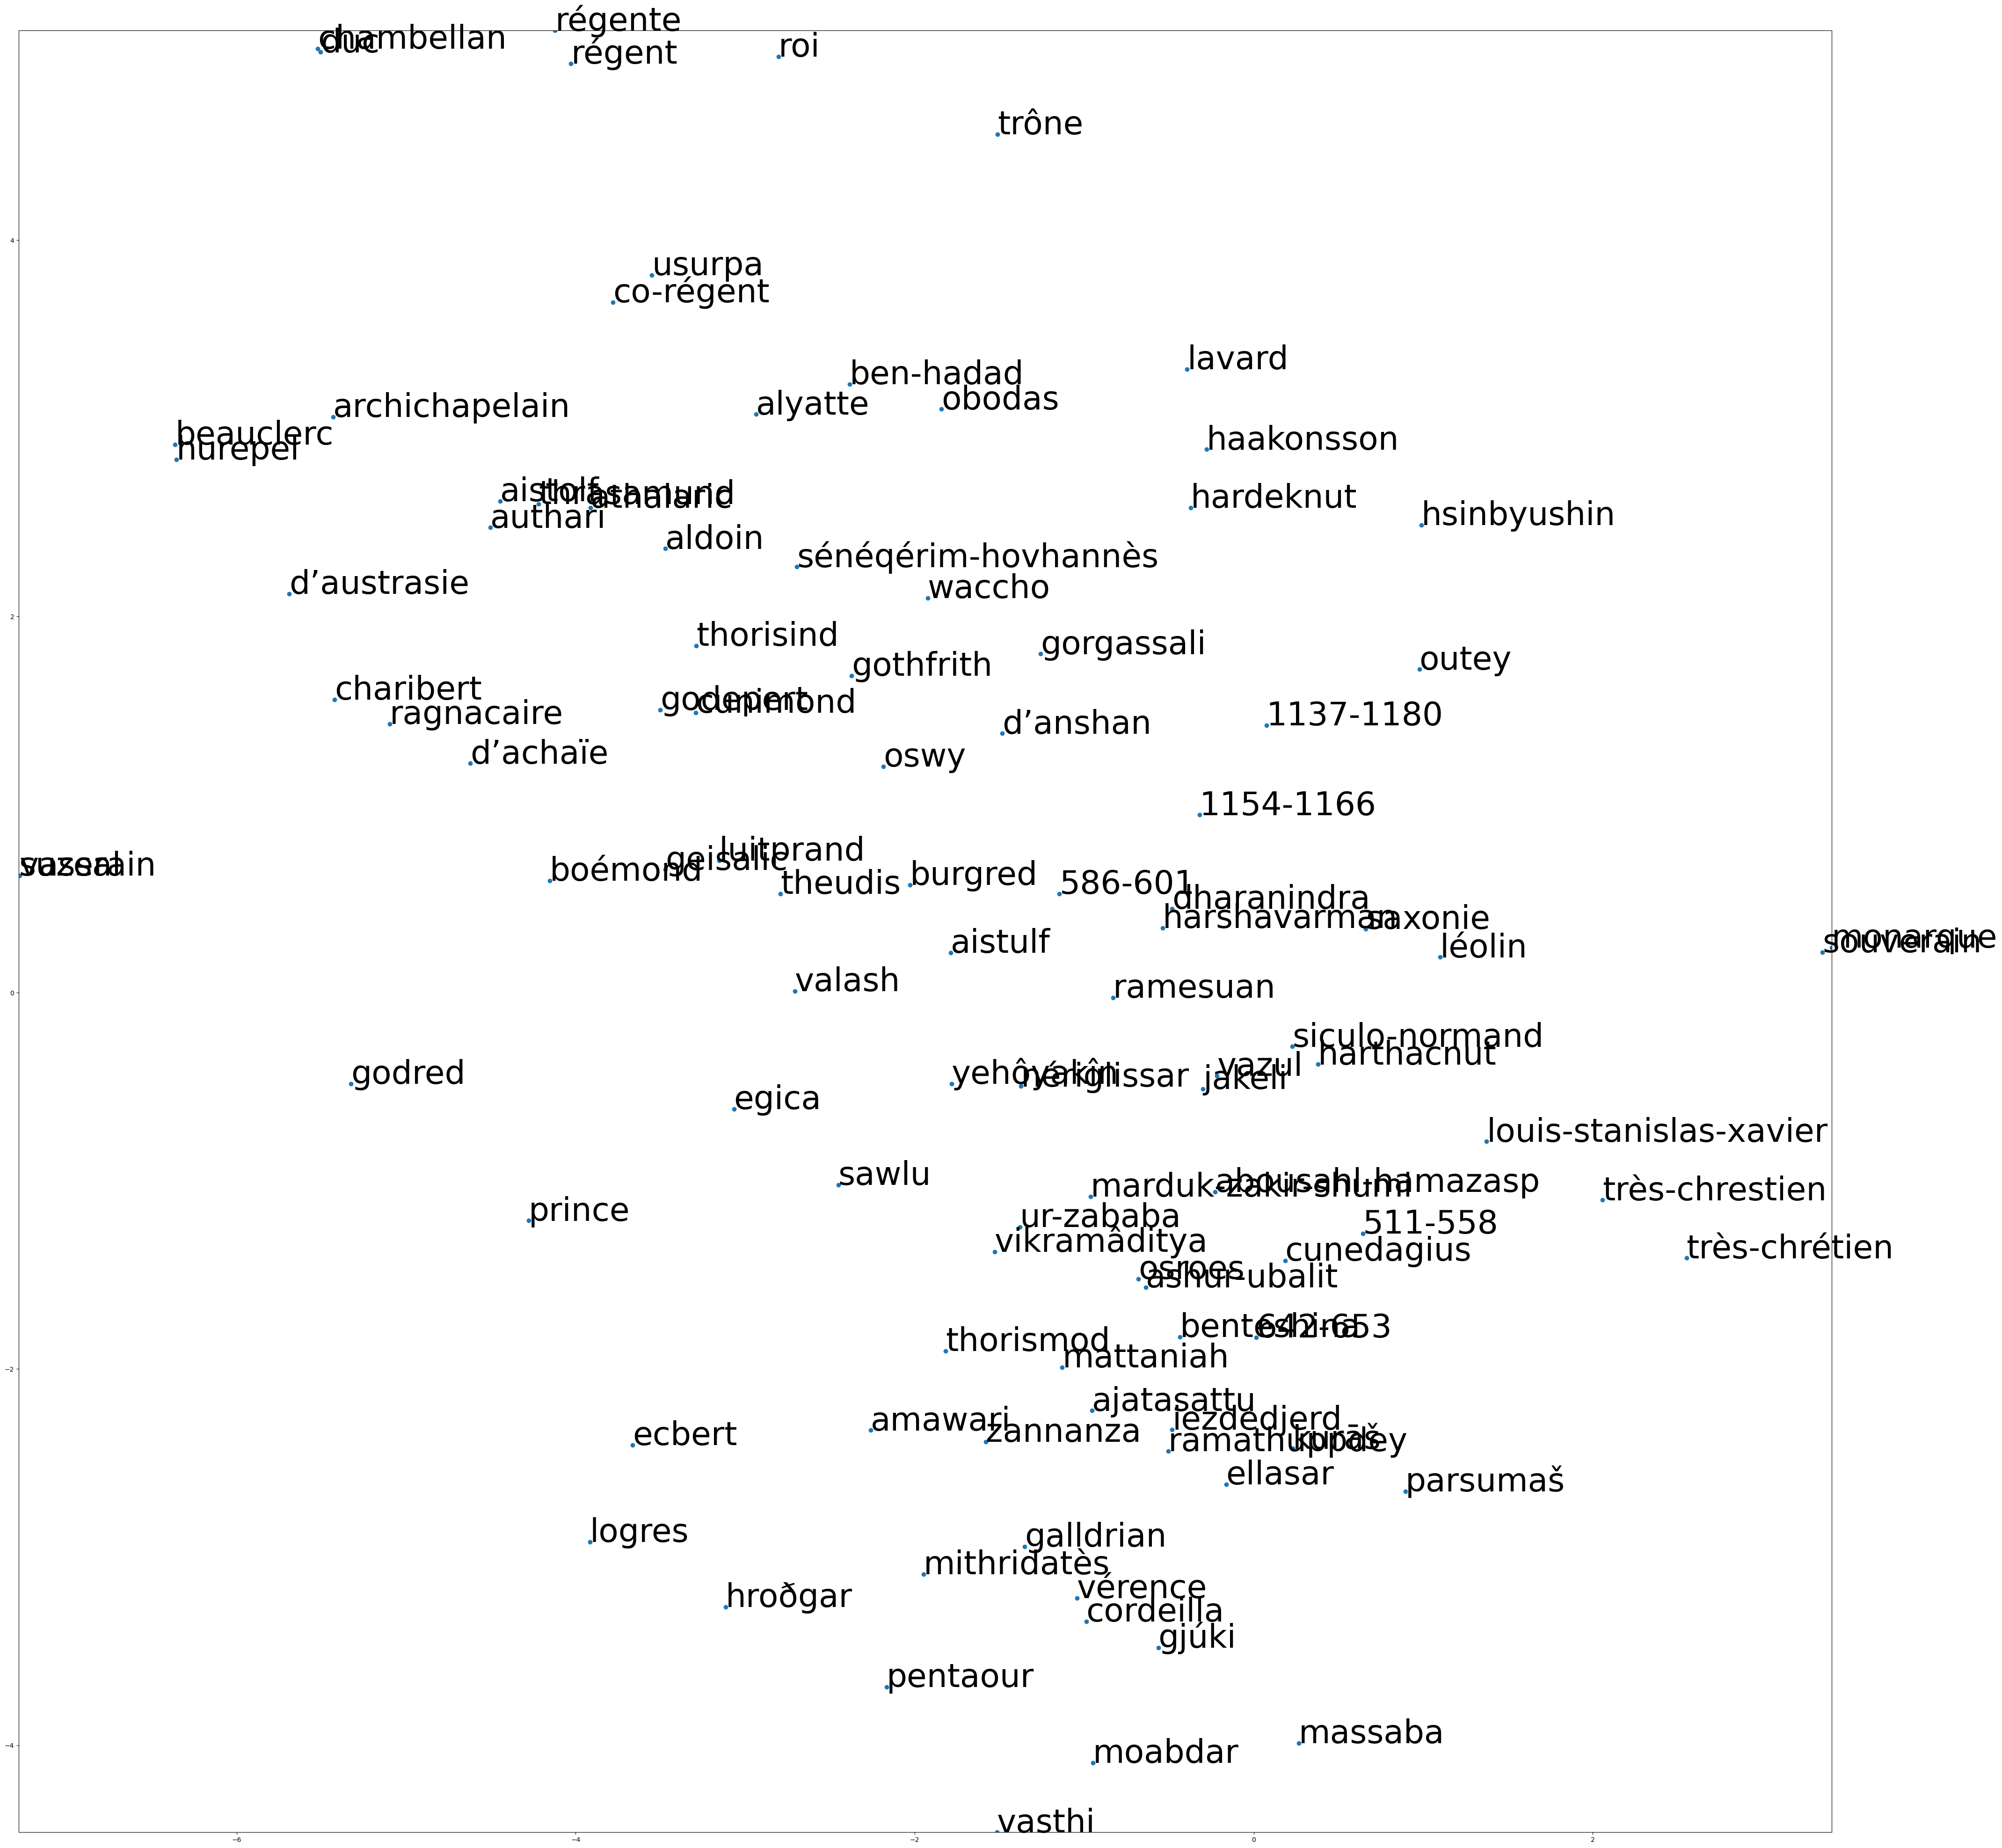

In [11]:
mot="roi"
display_closestwords_tsnescatterplot(modelFr, mot, 100,topn=100) 

### doesnt_match
doesnt_match cherche le vecteur le plus différent des autres dans une liste => chercher l'intrus

In [73]:
modelFr.doesnt_match(['électricien','mécanicien','peintre','platrier','maçon','prof'])

'prof'

In [77]:
modelFr.doesnt_match("triste rond magnifique vert".split(" "))

'triste'

## Anglais Fasttext (NLPL/9)
Corpus :
- English Wikipedia February 2017
    - anglais, min/maj, lemmes, tagged
    - 2252637050 tokens

Créé par Andrey Kutuzov (andreku@ifi.uio.no)

Paramètres :
- Fasttext Skipgram
- 300 dimensions
- fenêtre 5 mots
- taille du vocabulaire : 273930 mots

In [14]:
path_to_modelEn = os.path.join(data_path,'9/parameters.bin')
#Load W2V model. This will take some time.
modelEn = gensim.models.fasttext.load_facebook_vectors(path_to_modelEn)
print('done loading Word2Vec')

done loading Word2Vec


### Modèles FastText
Les modèles FastText traitent non seulement les contextes des mots mais aussi ceux des N-grams. De ce fait, ils sont capables de fournir des vecteurs pour des mots qui ne sont pas dans le corpus du moment que les N-grams qui les composent sont effectivement dans le corpus.

In [15]:
modelEn.most_similar("table_NOUN")

[('table', 0.5758581161499023),
 ('table-tennis', 0.5082424283027649),
 ('tablebase', 0.5024933218955994),
 ('Carpianum', 0.5017015933990479),
 ('carrom', 0.48716774582862854),
 ('mini-league', 0.46465975046157837),
 ('Cup/Plate', 0.45730823278427124),
 ('four-ball', 0.4528191387653351),
 ('gameboard', 0.45240479707717896),
 ('Eusebian', 0.4486585557460785)]

In [78]:
modelEn.most_similar(positive=["king","woman"],negative=["man"])

[('monarch', 0.6749916076660156),
 ('princess', 0.638053297996521),
 ('regnant', 0.6341029405593872),
 ('queen', 0.6316592693328857),
 ('royal', 0.6289796233177185),
 ('kingdom', 0.5857126116752625),
 ('queen-consort', 0.5852508544921875),
 ('ruler', 0.5702740550041199),
 ('kingship', 0.5696046948432922),
 ('throne', 0.5673027634620667)]

In [79]:
modelEn.most_similar(positive=["spling","went"],negative=["go"])

[('spline', 0.451389878988266),
 ('meshing', 0.44494715332984924),
 ('splint', 0.4156385660171509),
 ('compressional', 0.40449124574661255),
 ('jointed', 0.4029327929019928),
 ('shaping', 0.40187424421310425),
 ('compressive', 0.4004157781600952),
 ('weight-bearing', 0.4003019630908966),
 ('derwent', 0.3991227447986603),
 ('intergrowth', 0.3978770673274994)]

In [18]:
modelEn.most_similar("splang")

[('splanchnic', 0.6825660467147827),
 ('microcirculation', 0.6595008373260498),
 ('extravasation', 0.6080926656723022),
 ('vasculature', 0.6048488020896912),
 ('perfuse', 0.5823202133178711),
 ('endothelium', 0.5807482004165649),
 ('perivascular', 0.5788581371307373),
 ('nasolacrimal', 0.5781022310256958),
 ('radicular', 0.5777603983879089),
 ('pericardium', 0.5774173140525818)]

In [19]:
modelEn.doesnt_match("breakfast cereal field dinner lunch".split(" "))

'field'

## Représentation des voisinages en dendrogramme

In [20]:
def makeDendrogram(model):
    l = linkage(model.vectors, method='complete', metric='seuclidean')

    # calculate full dendrogram
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.ylabel('word')
    plt.xlabel('distance')

    dendrogram(
        l,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        orientation='left',
        leaf_label_func=lambda v: str(model.wv.index2word[v])
    )
    plt.show()

## Anglais
Corpus :
- British National Corpus
    - anglais, min/maj, lemmes, tagged
    - 1903181185 tokens

Créé par Andrey Kutuzov (andreku@ifi.uio.no)

Paramètres :
- Skipgram
- 300 dimensions
- fenêtre 10 mots
- taille du vocabulaire : 163473 mots 

In [21]:
path_to_modelBNC = os.path.join(data_path,'0/model.bin')
#Load W2V model. This will take some time.
modelBNC = KeyedVectors.load_word2vec_format(path_to_modelBNC, binary=True)
print('done loading Word2Vec')

done loading Word2Vec


In [22]:
modelBNC.most_similar("eat_VERB")

[('elevense_NOUN', 0.7003511190414429),
 ('fattening_ADJ', 0.6969293355941772),
 ('overindulgence_NOUN', 0.6924725770950317),
 ('high-fat_NOUN', 0.689265251159668),
 ('Dieters_PROPN', 0.6847372651100159),
 ('macrobiotic_ADJ', 0.6825564503669739),
 ('high-sugar_ADJ', 0.6802962422370911),
 ('meal-time_NOUN', 0.6788443922996521),
 ('spaghetti::bolognaise_NOUN', 0.678787887096405),
 ('rissole_NOUN', 0.6784420609474182)]

In [23]:
modelBNC.most_similar(positive=["king_NOUN","woman_NOUN"],negative=["man_NOUN"],topn=5)

[('queen_NOUN', 0.5085596442222595),
 ('coronation_NOUN', 0.48925459384918213),
 ('kingship_NOUN', 0.484601229429245),
 ('monarch_NOUN', 0.4805525839328766),
 ('alhred_ADJ', 0.4755530059337616)]

In [24]:
modelBNC.doesnt_match("breakfast_NOUN cereal_NOUN dinner_NOUN lunch_NOUN".split(" "))

'cereal_NOUN'